In [23]:
import  time

import torch
from torch.optim import lr_scheduler
import  torch.nn as nn
import torch.nn.functional as F
from torch.autograd  import Variable
from torch.utils.data import DataLoader

import torchvision.datasets as dsets
import torchvision.transforms as transforms


In [24]:
BATCH_SIZE = 100
criterion = nn.CrossEntropyLoss()
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [25]:
mean = [x/255 for x in [125.3, 123.0, 113.9]]
std = [x/255 for x in [63.0, 62.1, 66.7]]
n_train_samples = 5000

# 使用数据增强
train_set = dsets.CIFAR10(root='./data', train=True, transform=transforms.Compose([ 
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
]), download=True)
train_dl = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)
train_set.data = train_set.data[:n_train_samples]
train_set.targets = train_set.targets[:n_train_samples]

# 测试集也一样
test_set = dsets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
]), download=True)
test_dl = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
    

Files already downloaded and verified
Files already downloaded and verified


In [26]:
# 定义训练的辅助函数
def eval(model,criterion,dataloader):
    model.eval()
    loss, accuracy = 0., 0.
    
    # torch.no_grad()表示在计算图中不构建梯度计算
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            logits = model(batch_x)
            error = criterion(logits, batch_y)
            loss += error.item()
            
            probs, pred_y = logits.data.max(dim=1)
            accuracy += (pred_y == batch_y.data).float().sum()/batch_y.size(0)
            
        loss /= len(dataloader)
        accuracy = accuracy*100.0/len(dataloader)
        return loss, accuracy
    
def train_epoch(model, criterion, optimizer, dataloader):
    model.train()
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        logits = model(batch_x)
        error = criterion(logits, batch_y)
        error.backward()
        optimizer.step()

In [27]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        self.feature = nn.Sequential(nn.Conv2d(3,32,kernel_size=3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),
                                        nn.Conv2d(32,32,kernel_size=3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),
                                        # nn.Conv2d(32,32,kernel_size=3,padding=1),nn.ReLU(),
                                        nn.AvgPool2d(2,2),
                                        nn.Conv2d(32,64,kernel_size=3,padding=1),nn.BatchNorm2d(64),nn.ReLU(),
                                        nn.Conv2d(64,64,kernel_size=3,padding=1),nn.BatchNorm2d(64),nn.ReLU(),
                                        # nn.Conv2d(64,64,kernel_size=3,padding=1),nn.ReLU(),
                                        nn.AvgPool2d(2,2),
                                        nn.Conv2d(64,128,kernel_size=3,padding=1),nn.BatchNorm2d(128),nn.ReLU(),
                                        nn.Conv2d(128,128,kernel_size=3,padding=1),nn.BatchNorm2d(128),nn.ReLU(),
                                        # nn.Conv2d(128,128,kernel_size=3,padding=1),nn.ReLU(),
                                        nn.AvgPool2d(2,2))
                                
        self.classifier = nn.Sequential(nn.Linear(4*4*128,1000),nn.ReLU(True),nn.Dropout(),
                                        # nn.Linear(1000,500),nn.ReLU(True),nn.Dropout(),
                                        nn.Linear(1000,10))
        
    def forward(self,x):
        x = self.feature(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

In [28]:
net = VGG().to(device)
x = torch.randn(5,3,32,32).to(device)
y = net(x)
print(y.size())

torch.Size([5, 10])


In [29]:
nepochs = 50

net = VGG().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, nesterov=True)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[40], gamma=0.1)
learn_history = []

In [30]:
print('Training...')

for epoch in range(nepochs):
    since = time.time()
    train_epoch(net, criterion, optimizer, train_dl)
    
    if (epoch)%5 == 0:
        tr_loss, tr_acc = eval(net, criterion, train_dl)
        te_loss, te_acc = eval(net, criterion, test_dl)
        learn_history.append((tr_loss, tr_acc, te_loss, te_acc))
        now = time.time()
        print('[%3d/%d, %.0f seconds] |\t tr_err: %.1e, tr_acc: %.2f |\t te_err: %.1e, te_acc: %.2f' % (
            epoch+1, nepochs, now-since, tr_loss, tr_acc, te_loss, te_acc))


Training...
[  1/50, 115 seconds] |	 tr_err: 1.7e+00, tr_acc: 36.56 |	 te_err: 1.7e+00, te_acc: 37.64
[  6/50, 116 seconds] |	 tr_err: 1.4e+00, tr_acc: 54.02 |	 te_err: 1.4e+00, te_acc: 51.95
[ 11/50, 114 seconds] |	 tr_err: 1.0e+00, tr_acc: 63.72 |	 te_err: 1.1e+00, te_acc: 60.51
[ 16/50, 115 seconds] |	 tr_err: 9.6e-01, tr_acc: 65.70 |	 te_err: 1.3e+00, te_acc: 59.67
[ 21/50, 114 seconds] |	 tr_err: 6.6e-01, tr_acc: 75.56 |	 te_err: 1.0e+00, te_acc: 66.11
[ 26/50, 114 seconds] |	 tr_err: 5.2e-01, tr_acc: 81.56 |	 te_err: 1.0e+00, te_acc: 69.46
[ 31/50, 115 seconds] |	 tr_err: 4.9e-01, tr_acc: 83.00 |	 te_err: 1.1e+00, te_acc: 68.83
[ 36/50, 114 seconds] |	 tr_err: 3.2e-01, tr_acc: 88.08 |	 te_err: 9.9e-01, te_acc: 72.09
[ 41/50, 115 seconds] |	 tr_err: 2.4e-01, tr_acc: 92.08 |	 te_err: 9.9e-01, te_acc: 73.16
[ 46/50, 114 seconds] |	 tr_err: 2.3e-01, tr_acc: 91.64 |	 te_err: 1.1e+00, te_acc: 72.64


In [37]:
[x[3].to('cpu') for x in learn_history]

[tensor(37.6400),
 tensor(51.9500),
 tensor(60.5100),
 tensor(59.6700),
 tensor(66.1100),
 tensor(69.4600),
 tensor(68.8300),
 tensor(72.0900),
 tensor(73.1600),
 tensor(72.6400)]

Text(0, 0.5, 'accuracy')

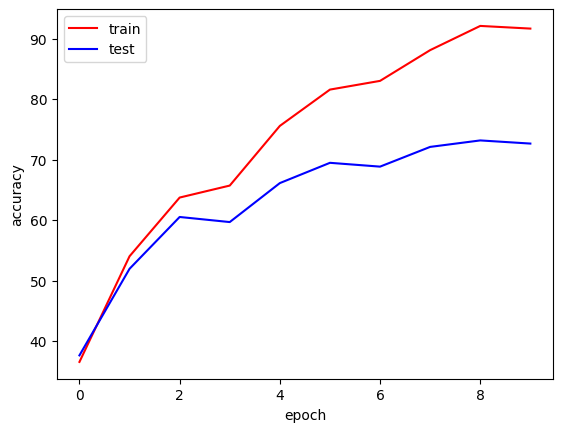

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([x[1].to('cpu') for x in learn_history],'r' ,label='train')
plt.plot([x[3].to('cpu') for x in learn_history],'b', label='test')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')